Image Classification With SVM in Python

In [2]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import os
import re
import pickle
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [3]:
# cleaning function
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")

**BUNGA**

In [4]:
# get data
dataset_dir = "/content/drive/MyDrive/dataset isna/bunga"

imgs = [] #list image matrix
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    img_files = os.listdir(os.path.join(dataset_dir, folder))
    len_files = len(img_files)
    for i, filename in enumerate(img_files):
        img = cv2.imread(os.path.join(dataset_dir, folder, filename))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # grayscale

        h, w = gray.shape
        # print(h)
        # print(w)
        # ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
        ymin, ymax, xmin, xmax = h//2, h*2//3, w//2, w*2//3
        crop = gray[ymin:ymax, xmin:xmax]

        resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5) # resize

        imgs.append(gray)
        labels.append(normalize_label(os.path.splitext(folder)[0]))
        descs.append(normalize_desc(folder, ''))

        print_progress(i, len_files, folder, '', filename)

89
vanda


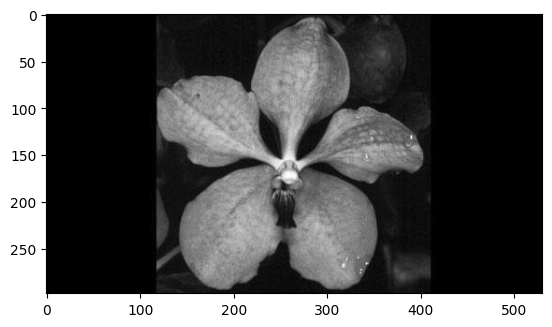

In [5]:
#showing random pic

%matplotlib inline

i = np.random.randint(len(imgs))
print(i)
print(labels[i])
# cv2.imshow('rice',imgs[i])

# cv2.waitKey(0)
# cv2.destroyAllWindows()

# image = cv2.imread(imgs[i])

#Show the image with matplotlib
plt.imshow(imgs[i], cmap = 'gray')
plt.show()

In [6]:
imgs[i].shape

(298, 530)

In [7]:
#calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    glcm = greycomatrix(img, distances=dists, angles=agls, levels=lvl,symmetric=sym, normed=norm)
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]

    feature = []
    for item in glcm_props:
            feature.append(item)
    feature.append(label)

    return feature

In [8]:
# glcm
properties = ['correlation', 'homogeneity', 'contrast', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [9]:
glcm_df = pd.DataFrame(glcm_all_agls, columns = columns)
glcm_df.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label
0,0.932427,0.929065,0.925855,0.914806,0.278376,0.277755,0.282253,0.249971,122.354054,128.797507,134.962733,154.691322,0.026899,0.026894,0.026809,0.025041,cattleya
1,0.733348,0.734258,0.738818,0.699988,0.070071,0.066663,0.069762,0.065956,1161.492359,1142.776239,1130.838667,1291.698407,0.010385,0.010286,0.010482,0.010309,cattleya
2,0.923297,0.916303,0.924656,0.909694,0.169843,0.158701,0.175505,0.163967,538.389702,586.535564,528.303173,632.919929,0.016280,0.015696,0.016576,0.016059,cattleya
3,0.786448,0.796898,0.808664,0.765428,0.084609,0.083471,0.091623,0.080513,1386.322253,1321.463793,1246.086432,1526.179395,0.009148,0.009037,0.009501,0.008977,cattleya
4,0.934103,0.926045,0.946661,0.933168,0.171807,0.167556,0.193272,0.159914,518.395052,579.477564,418.005016,523.622598,0.013324,0.012930,0.014362,0.012933,cattleya


In [10]:
glcm_df2 = glcm_df.join(pd.get_dummies(glcm_df['label'])).drop('label',axis = 1)

###########################
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(glcm_df['label'])
glcm_df['label_enc'] = le.transform(glcm_df['label'])

In [11]:
glcm_df

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label,label_enc
0,0.932427,0.929065,0.925855,0.914806,0.278376,0.277755,0.282253,0.249971,122.354054,128.797507,134.962733,154.691322,0.026899,0.026894,0.026809,0.025041,cattleya,0
1,0.733348,0.734258,0.738818,0.699988,0.070071,0.066663,0.069762,0.065956,1161.492359,1142.776239,1130.838667,1291.698407,0.010385,0.010286,0.010482,0.010309,cattleya,0
2,0.923297,0.916303,0.924656,0.909694,0.169843,0.158701,0.175505,0.163967,538.389702,586.535564,528.303173,632.919929,0.016280,0.015696,0.016576,0.016059,cattleya,0
3,0.786448,0.796898,0.808664,0.765428,0.084609,0.083471,0.091623,0.080513,1386.322253,1321.463793,1246.086432,1526.179395,0.009148,0.009037,0.009501,0.008977,cattleya,0
4,0.934103,0.926045,0.946661,0.933168,0.171807,0.167556,0.193272,0.159914,518.395052,579.477564,418.005016,523.622598,0.013324,0.012930,0.014362,0.012933,cattleya,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.818863,0.800234,0.829860,0.812950,0.085507,0.080359,0.109678,0.086925,1439.600466,1589.548735,1361.813537,1488.328639,0.013981,0.013414,0.015152,0.013988,vanda,3
96,0.677385,0.637640,0.697524,0.634192,0.056419,0.052030,0.058483,0.052611,2218.668251,2496.176285,2090.861241,2519.755743,0.008124,0.007721,0.008198,0.007840,vanda,3
97,0.687708,0.634474,0.647814,0.650843,0.054707,0.048572,0.049884,0.047995,2253.061196,2632.912604,2536.531561,2515.234791,0.007702,0.007305,0.007269,0.007206,vanda,3
98,0.834583,0.827230,0.849354,0.821340,0.114260,0.087867,0.094247,0.086776,686.861648,714.953930,629.338945,739.320401,0.015022,0.013312,0.013793,0.013296,vanda,3


In [12]:
# shuffle data
glcm_df3 = glcm_df.drop('label',axis=1)

from sklearn.utils import shuffle
shuffled = shuffle(glcm_df3, random_state=1)
shuffled.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label_enc
80,0.848562,0.854617,0.865159,0.852067,0.330926,0.332863,0.337343,0.332625,1706.527720,1638.149393,1517.909458,1666.878704,0.069336,0.069519,0.069910,0.068951,3
84,0.607251,0.592861,0.635562,0.613670,0.042122,0.037854,0.043884,0.042208,2136.714181,2200.346540,1976.298125,2087.845130,0.007010,0.006876,0.007123,0.007070,3
33,0.660562,0.607138,0.674093,0.600238,0.057434,0.046220,0.054309,0.046464,3785.242059,4326.042517,3588.062806,4401.842413,0.013743,0.010502,0.010835,0.010541,1
81,0.852479,0.837032,0.840934,0.820051,0.682646,0.675319,0.677510,0.671418,989.570980,1098.734879,1069.809789,1213.224652,0.644010,0.639359,0.641541,0.638693,3
93,0.729685,0.695343,0.739486,0.701582,0.205046,0.204087,0.253117,0.192489,1275.289790,1419.757932,1208.948269,1390.706859,0.021308,0.021026,0.024328,0.020636,3


In [13]:
# train test split 80-20

from sklearn.model_selection import train_test_split

X = shuffled.drop('label_enc',axis=1)
y = shuffled['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm


clf = OneVsRestClassifier(SVC()).fit(X_train,y_train)
clf_lin = OneVsRestClassifier(SVC(kernel = 'linear')).fit(X_train,y_train)
clf_poly = OneVsRestClassifier(SVC(kernel = 'poly')).fit(X_train,y_train)
clf_sig = OneVsRestClassifier(SVC(kernel = 'sigmoid')).fit(X_train,y_train)

In [15]:
# Train pred

y_pred = clf.predict(X_train)
y_pred_lin = clf_lin.predict(X_train)
y_pred_poly = clf_poly.predict(X_train)
y_pred_sig = clf_sig.predict(X_train)

In [16]:
print('Train Score')
print(f"SVM - RBF      :{round(accuracy_score(y_train,y_pred),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_train,y_pred_lin),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_train,y_pred_poly),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_train,y_pred_sig),3)*100}%")

Train Score
SVM - RBF      :42.5%
SVM - Linear   :50.0%
SVM - Poly     :40.0%
SVM - Sigmoid  :17.5%


In [17]:
# Test pred

y_pred_test = clf.predict(X_test)
y_pred_lin_test = clf_lin.predict(X_test)
y_pred_poly_test = clf_poly.predict(X_test)
y_pred_sig_test = clf_sig.predict(X_test)

In [18]:
print('Test Score')
print(f"SVM - RBF      :{round(accuracy_score(y_test,y_pred_test),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_test,y_pred_lin_test),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_test,y_pred_poly_test),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_test,y_pred_sig_test),3)*100}%")

Test Score
SVM - RBF      :60.0%
SVM - Linear   :50.0%
SVM - Poly     :20.0%
SVM - Sigmoid  :20.0%


In [19]:
y_pred = clf_lin.predict(X_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[0 0 3 1 3 0 3 2 3 0 2 2 2 1 0 1 0 0 0 1]
The actual data is:
[0 0 2 1 3 1 3 1 3 3 3 2 2 3 0 3 0 2 2 3]
The model is 50.0% accurate


In [21]:
# Save model

bunga_pkl = 'SVM_Bunga_With_GLCM.pkl'
pickle.dump(clf_lin, open(bunga_pkl, 'wb'))

**DAUN**

In [22]:
dataset_dir = "/content/drive/MyDrive/dataset isna/daun"

imgs = [] #list image matrix
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    img_files = os.listdir(os.path.join(dataset_dir, folder))
    len_files = len(img_files)
    for i, filename in enumerate(img_files):
        img = cv2.imread(os.path.join(dataset_dir, folder, filename))

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        h, w = gray.shape
        # print(h)
        # print(w)
        # ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
        ymin, ymax, xmin, xmax = h//2, h*2//3, w//2, w*2//3
        crop = gray[ymin:ymax, xmin:xmax]

        resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)

        imgs.append(gray)
        labels.append(normalize_label(os.path.splitext(folder)[0]))
        descs.append(normalize_desc(folder, ''))

        print_progress(i, len_files, folder, '', filename)

In [23]:
imgs[i].shape

(480, 480)

In [24]:
#calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    glcm = greycomatrix(img, distances=dists, angles=agls, levels=lvl,symmetric=sym, normed=norm)
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]

    feature = []
    for item in glcm_props:
            feature.append(item)
    feature.append(label)

    return feature

In [25]:
properties = ['correlation', 'homogeneity', 'contrast', 'energy']

glcm_all_agls = []
for img, label in zip(imgs, labels):
    glcm_all_agls.append(
            calc_glcm_all_agls(img,
                                label,
                                props=properties)
                            )

columns = []
angles = ['0', '45', '90','135']
for name in properties :
    for ang in angles:
        columns.append(name + "_" + ang)

columns.append("label")

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

In [26]:
glcm_df = pd.DataFrame(glcm_all_agls, columns = columns)
glcm_df.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label
0,0.792570,0.809164,0.771885,0.729713,0.194910,0.172903,0.193455,0.173495,960.718943,887.789047,1058.208154,1257.394539,0.025932,0.023270,0.024800,0.023790,vanda
1,0.604872,0.530210,0.591296,0.596162,0.585171,0.555200,0.565747,0.561384,1669.159074,1993.911864,1719.421651,1713.997367,0.238664,0.230108,0.234467,0.230928,vanda
2,0.854309,0.733404,0.728979,0.774067,0.393932,0.339887,0.339261,0.348875,1101.829053,2023.069522,2046.606404,1714.506717,0.059998,0.053895,0.053757,0.054868,vanda
3,0.890477,0.861315,0.887116,0.865518,0.108217,0.100968,0.131235,0.105696,761.162020,964.370522,787.239280,935.022917,0.011435,0.011028,0.012471,0.011321,vanda
4,0.767489,0.712348,0.710660,0.711562,0.068111,0.058186,0.059284,0.059458,1302.623604,1608.810248,1615.731102,1613.184421,0.008477,0.007926,0.007826,0.007893,vanda


In [27]:
glcm_df2 = glcm_df.join(pd.get_dummies(glcm_df['label'])).drop('label',axis = 1)

###########################
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(glcm_df['label'])
glcm_df['label_enc'] = le.transform(glcm_df['label'])

In [28]:
glcm_df

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label,label_enc
0,0.792570,0.809164,0.771885,0.729713,0.194910,0.172903,0.193455,0.173495,960.718943,887.789047,1058.208154,1257.394539,0.025932,0.023270,0.024800,0.023790,vanda,3
1,0.604872,0.530210,0.591296,0.596162,0.585171,0.555200,0.565747,0.561384,1669.159074,1993.911864,1719.421651,1713.997367,0.238664,0.230108,0.234467,0.230928,vanda,3
2,0.854309,0.733404,0.728979,0.774067,0.393932,0.339887,0.339261,0.348875,1101.829053,2023.069522,2046.606404,1714.506717,0.059998,0.053895,0.053757,0.054868,vanda,3
3,0.890477,0.861315,0.887116,0.865518,0.108217,0.100968,0.131235,0.105696,761.162020,964.370522,787.239280,935.022917,0.011435,0.011028,0.012471,0.011321,vanda,3
4,0.767489,0.712348,0.710660,0.711562,0.068111,0.058186,0.059284,0.059458,1302.623604,1608.810248,1615.731102,1613.184421,0.008477,0.007926,0.007826,0.007893,vanda,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.713142,0.763981,0.878800,0.729870,0.105197,0.110770,0.176779,0.112385,1160.301187,945.828075,485.137132,1082.555351,0.012494,0.012995,0.017538,0.013233,cattleya,0
96,0.771408,0.773587,0.849977,0.766701,0.106572,0.108685,0.158012,0.110695,945.135704,939.746259,625.257906,968.298697,0.013209,0.013295,0.016141,0.013485,cattleya,0
97,0.764626,0.771334,0.890588,0.796383,0.103062,0.106568,0.181667,0.109685,1355.604818,1319.039456,630.121965,1174.546608,0.011363,0.011660,0.015436,0.011817,cattleya,0
98,0.616579,0.656979,0.860035,0.650496,0.074394,0.080869,0.139439,0.080289,1894.882419,1695.784172,691.838064,1728.355910,0.009736,0.010182,0.013657,0.010156,cattleya,0


In [29]:
# shuffle data
glcm_df3 = glcm_df.drop('label',axis=1)

from sklearn.utils import shuffle
shuffled = shuffle(glcm_df3, random_state=1)
shuffled.head()

,correlation_0,correlation_45,correlation_90,correlation_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,contrast_0,contrast_45,contrast_90,contrast_135,energy_0,energy_45,energy_90,energy_135,label_enc
80,0.785098,0.757715,0.851846,0.818802,0.098633,0.083141,0.109953,0.092428,1178.194401,1320.247445,803.863784,987.236008,0.010728,0.009770,0.011111,0.010296,0
84,0.617255,0.597754,0.714028,0.664735,0.068288,0.064636,0.097786,0.074860,2252.695938,2368.016057,1680.411600,1973.568200,0.009660,0.009576,0.011565,0.010001,0
33,0.681566,0.630358,0.655313,0.649413,0.045525,0.038772,0.044513,0.041709,2163.972752,2523.158290,2359.710838,2392.868255,0.006610,0.006307,0.006509,0.006415,1
81,0.750013,0.767103,0.881212,0.783096,0.097227,0.106517,0.175608,0.107914,1089.245957,1019.369695,522.288392,949.349943,0.011617,0.012062,0.016002,0.012052,0
93,0.710300,0.763012,0.789813,0.668726,0.093222,0.095330,0.130920,0.088343,1564.261581,1278.073464,1133.923402,1786.904509,0.010679,0.010952,0.012915,0.010501,0


In [30]:
# Train test split 80-20

from sklearn.model_selection import train_test_split

X = shuffled.drop('label_enc',axis=1)
y = shuffled['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm

clf = OneVsRestClassifier(SVC()).fit(X_train,y_train)
clf_lin = OneVsRestClassifier(SVC(kernel = 'linear')).fit(X_train,y_train)
clf_poly = OneVsRestClassifier(SVC(kernel = 'poly')).fit(X_train,y_train)
clf_sig = OneVsRestClassifier(SVC(kernel = 'sigmoid')).fit(X_train,y_train)

In [32]:
# Train pred

y_pred = clf.predict(X_train)
y_pred_lin = clf_lin.predict(X_train)
y_pred_poly = clf_poly.predict(X_train)
y_pred_sig = clf_sig.predict(X_train)

In [34]:
print('Train Score')
print(f"SVM - RBF      :{round(accuracy_score(y_train,y_pred),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_train,y_pred_lin),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_train,y_pred_poly),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_train,y_pred_sig),3)*100}%")

Train Score
SVM - RBF      :55.00000000000001%
SVM - Linear   :72.5%
SVM - Poly     :56.2%
SVM - Sigmoid  :41.199999999999996%


In [35]:
# Test pred

y_pred_test = clf.predict(X_test)
y_pred_lin_test = clf_lin.predict(X_test)
y_pred_poly_test = clf_poly.predict(X_test)
y_pred_sig_test = clf_sig.predict(X_test)

In [36]:
print('Test Score')
print(f"SVM - RBF      :{round(accuracy_score(y_test,y_pred_test),3)*100}%")
print(f"SVM - Linear   :{round(accuracy_score(y_test,y_pred_lin_test),3)*100}%")
print(f"SVM - Poly     :{round(accuracy_score(y_test,y_pred_poly_test),3)*100}%")
print(f"SVM - Sigmoid  :{round(accuracy_score(y_test,y_pred_sig_test),3)*100}%")

Test Score
SVM - RBF      :55.00000000000001%
SVM - Linear   :80.0%
SVM - Poly     :60.0%
SVM - Sigmoid  :45.0%


In [37]:
y_pred = clf_lin.predict(X_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[3 1 2 1 0 1 0 1 0 0 0 2 0 0 3 1 3 0 2 0]
The actual data is:
[3 3 2 1 0 1 0 1 0 0 0 2 2 0 3 0 3 2 2 0]
The model is 80.0% accurate


In [38]:
# Save model

daun_pkl = 'SVM_Daun_With_GLCM.pkl'
pickle.dump(clf_lin, open(daun_pkl, 'wb'))